In this section we want to set up a JuliaElectricGrid simulation utilizing a reinforcement learning agent from `ReinforcementLearning.jl`.
We start with the same code we used in the `Reinforcement Learning in Larger Grids` section (or in the `RL_Complex_DEMO` notebook, respectively).

In [1]:
using JEG
using ReinforcementLearning
using StableRNGs
using Flux
using Flux.Losses
using IntervalSets

CM = [0.0   1.0  0
     -1.0   0.0  2.0
     0  -2.0  0.0]

parameters =
Dict{Any, Any}(
    "source" => Any[
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "control_type" => "RL",
                        "mode" => "my_ddpg",
                        "fltr" => "L",
                        "i_limit"      => 2000.),
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "fltr" => "LC",
                        "control_type" =>
                        "RL", "mode" => "my_ddpg"),
                    Dict{Any, Any}(
                        "pwr" => 200e3,
                        "fltr" => "L",
                        "control_type" =>
                        "RL", "mode" => "my_ddpg",
                        "i_limit"      => 2000.),
                    ],
        #"load"   => Any[
        #    Dict{Any, Any}("impedance" => "RLC", "R" => R_load, "v_limit" => 1e4, "i_limit" => 1e4)
        #    ],
    "grid" => Dict{Any, Any}(
        "phase" => 1,
        "ramp_end" => 0.04,)
)

function reference(t)

    #return [-1., -2.]
    return [-10., 230., -15.]
end

featurize_ddpg = function(state, env, name)
    if name == "my_ddpg"
        #norm_ref = env.nc.parameters["source"][1]["i_limit"]
        #state = vcat(state, reference(env.t)/norm_ref)

        refs = reference(env.t)
        refs[1] = refs[1] / env.nc.parameters["source"][1]["i_limit"]
        refs[2] = refs[2] / env.nc.parameters["source"][2]["v_limit"]
        refs[3] = refs[3] / env.nc.parameters["source"][3]["i_limit"]

        state = vcat(state, refs)
    end
end

function reward_function(env, name=nothing)
    if name == "my_ddpg"
        #println("Inside reward")
        state_to_control_1 = env.state[findfirst(x -> x == "source1_i_L1", env.state_ids)]
        state_to_control_2 = env.state[findfirst(x -> x == "source2_v_C_filt", env.state_ids)]
        state_to_control_3 = env.state[findfirst(x -> x == "source3_i_L1", env.state_ids)]

        state_to_control = [state_to_control_1, state_to_control_2, state_to_control_3]
        #state_to_control = [state_to_control_1, state_to_control_3]

        if any(abs.(state_to_control).>1)
            return -1
        else
            refs = reference(env.t)
            refs[1] = refs[1] / env.nc.parameters["source"][1]["i_limit"]
            refs[2] = refs[2] / env.nc.parameters["source"][2]["v_limit"]
            refs[3] = refs[3] / env.nc.parameters["source"][3]["i_limit"]

            r = 1-1/3*(sum((abs.(refs - state_to_control)/2).^0.5))

            #refs = reference(env.t)
            #norm_ref = env.nc.parameters["source"][1]["i_limit"]
            #r = 1-1/3*(sum((abs.(refs/norm_ref - state_to_control)/2).^0.5))

            #println(r)
            return r
        end
    else
        return 1
    end

end

env = ElectricGridEnv(
    CM = CM,
    parameters = parameters,
    t_end = 1,
    featurize = featurize_ddpg,
    reward_function = reward_function,
    action_delay = 0,
    verbosity = 2);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

CABLE LAYOUT BASED ON POWER FLOW EQUATIONS:


termination_status = INVALID_MODEL
primal_status      = UNKNOWN_RESULT_STATUS
objective_value    = 0.0



optimizer_status["termination_status"] = MathOptInterface.INVALID_MODEL




2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(3)
    Dimension 2, ["v", "theta", "P", "Q"]
And data, a 3×4 Matrix{Float64}:
 

230.0  0.0  0.0  0.0
 230.0  0.0  0.0  0.0
 230.0  0.0  0.0  0.0
asdasdasd

2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, Base.OneTo(2)
    Dimension 2, ["radius", "D-to-neutral"]
And data, a 2×2 Matrix{Float64}:
 0.0375  0.1922763744
 0.0375  0.1922763744


┌ Warning: Power flow equation not solveable! Maybe parameter setting invalid.
│                   Default values are used for cable parameters
└ @ JEG e:\Documents\dare\src\power_system_theory.jl:1132


┌ Info: Normalization is done based on the defined parameter limits.
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:329


┌ Info: Time simulation run time: 1.0 [s] ~> 10001 steps
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:330


Next, we define a ddpg agent, just like shown in [the ReinforcementLearning.jl examples](https://juliareinforcementlearning.org/docs/experiments/experiments/Policy%20Gradient/JuliaRL_DDPG_Pendulum/#JuliaRL\\_DDPG\\_Pendulum). Note that we have to call `state` by `JEG.state` since `JEG` and `ReinforcementLearning` both export state and we imported them both at the beginning.

In [2]:
rng = StableRNG(1)
init = Flux.glorot_uniform(rng)

ns = length(JEG.state(env, "my_ddpg"))#length(env.agent_dict["my_ddpg"]["state_ids"])
na = length(env.agent_dict["my_ddpg"]["action_ids"])

CreateActor() = Chain(
    Dense(ns, 30, relu; init = init),
    Dense(30, 30, relu; init = init),
    Dense(30, na, tanh; init = init),
) |> gpu

CreateCritic() = Chain(
    Dense(ns + na, 30, relu; init = init),
    Dense(30, 30, relu; init = init),
    Dense(30, 1; init = init),
) |> gpu

agent = Agent(
    policy = DDPGPolicy(
        behavior_actor = NeuralNetworkApproximator(
            model = CreateActor(),
            optimizer = ADAM(),
        ),
        behavior_critic = NeuralNetworkApproximator(
            model = CreateCritic(),
            optimizer = ADAM(),
        ),
        target_actor = NeuralNetworkApproximator(
            model = CreateActor(),
            optimizer = ADAM(),
        ),
        target_critic = NeuralNetworkApproximator(
            model = CreateCritic(),
            optimizer = ADAM(),
        ),
        γ = 0.99f0,
        ρ = 0.995f0,
        na = na,
        batch_size = 64,
        start_steps = 1000,
        start_policy = RandomPolicy(-1.0..1.0; rng = rng),
        update_after = 50,#1000,
        update_freq = 1,
        act_limit = 1.0,
        act_noise = 0.001,
        rng = rng,
    ),
    trajectory = CircularArraySARTTrajectory(
        capacity = 10000,
        state = Vector{Float32} => (ns,),
        action = Float32 => (na, ),
    ),
);

Now that we have defined our own agent, we can plug everything together and run the learning like we have already done it in the other examples.

┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535


┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


Progress:  10%|█████                                    |  ETA: 0:18:41

┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
Progress:  15%|███████                                  |  ETA: 0:12:06

┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
Progress:  25%|███████████                              |  ETA: 0:06:29

┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537
Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀        
                 ┌────────────────────────────────────────┐        
         328.685 │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ my_ddpg
                 │⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⡎⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⢰⠁⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⢸⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⡜⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
   Score         │⠀⠀⠀⠀⡇⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⢀⡠⠇⠀⠀⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠁⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⢸⠀⣀⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠈⠉⠀⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│        
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

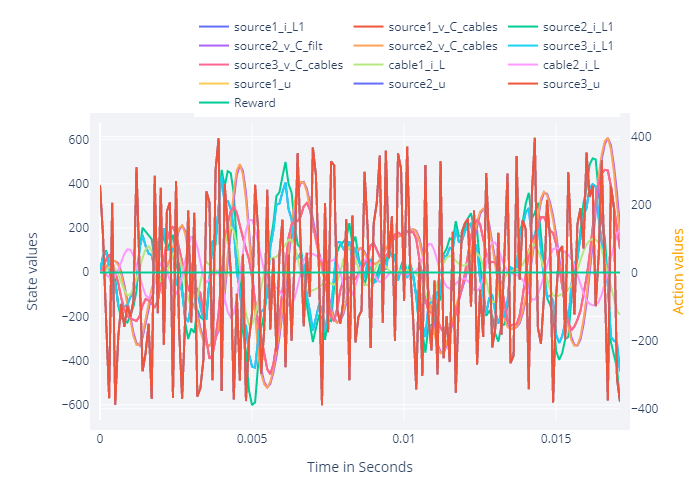

In [3]:
my_custom_agents = Dict("my_ddpg" => agent)

controllers = SetupAgents(env, my_custom_agents)

hook_learn = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

Learn(controllers, env, num_episodes = 20, hook=hook_learn)

RenderHookResults(hook = hook_learn,
                    episode = 1,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)

In the next part we expect some differences since external agents do not support "learning" and "non-learning" mode. This means that even though we run a `Simulate` run we expect to see action noise in the results.

┌ Warning: The state(s) Any["source2_i_L1"] exceeded limit(s)
│                     -> episode abort
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:535
┌ Warning: Corresponding limit(s): [629.5153538513777],
│                     corresponding index: [3]
└ @ JEG e:\Documents\dare\src\electric_grid_env.jl:537


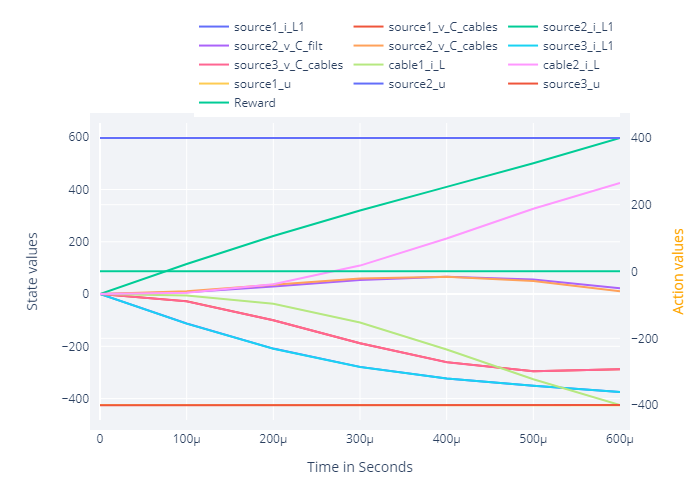

In [4]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids)

hook = Simulate(controllers, env, hook=hook)


RenderHookResults(hook = hook,
                    states_to_plot  = env.state_ids,
                    actions_to_plot = env.action_ids,
                    plot_reward=true)